# Models - GRU and LSTM - draft (JR_01)

In [460]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from keras.layers import Bidirectional, Dense, Dropout, GRU, Input, LSTM
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

In [601]:
# loading dataset - CHANGE TO CORRECT LOADING THROUGH SCRIPTS!!!!
wkdir = '../data/raw/'

# df_errors = pd.read_csv(wkdir + 'PdM_errors.csv', parse_dates=['datetime'])
df_failures = pd.read_csv(wkdir + 'PdM_failures.csv', parse_dates=['datetime'])
df_machines = pd.read_csv(wkdir + 'PdM_machines.csv')
df_maint = pd.read_csv(wkdir + 'PdM_maint.csv', parse_dates=['datetime'])
df_telemetry = pd.read_csv(wkdir + 'PdM_telemetry.csv', parse_dates=['datetime'])

In [602]:
df_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [603]:
# plt.hist(df_telemetry['vibration'], bins=100)

In [604]:
# print(df_telemetry.head())

In [605]:
# A total of 876100 rows (telemetry)

In [606]:
# Create dummies
# df_err = pd.get_dummies(df_errors, columns = ['errorID'], dtype=int, prefix='', prefix_sep='').groupby(['datetime','machineID']).sum().reset_index()
df_fail = pd.get_dummies(df_failures, columns = ['failure'], dtype=int, prefix='fail').groupby(['machineID','datetime']).sum().reset_index()
df_mnt = pd.get_dummies(df_maint, columns = ['comp'], dtype=int, prefix='maint').groupby(['machineID','datetime']).sum().reset_index()

In [607]:
# transform values to numbers
# df_failures['failure'] = df_failures['failure'].str.removeprefix('comp').astype(int)
df_machines['model'] = df_machines['model'].str.removeprefix('model').astype(int)
# df_machines['age'] = df_machines['age'].astype(np.float32)

In [608]:
# merging dataset
# merge all dfs into one.
# df_tele_err = pd.merge(df_telemetry, df_err, how='left', on=['datetime', 'machineID'])
df_tele_fail = pd.merge(df_telemetry, df_fail, how='left', on=['datetime', 'machineID'])
df_tele_fail_maint = pd.merge(df_tele_fail, df_mnt, how='left', on=['datetime', 'machineID'])
df_all = pd.merge(df_tele_fail_maint, df_machines, how='left', on="machineID")


In [609]:
print(df_all.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  fail_comp1  fail_comp2  fail_comp3  fail_comp4  maint_comp1  \
0  45.087686         NaN         NaN         NaN         NaN          NaN   
1  43.413973         NaN         NaN         NaN         NaN          NaN   
2  34.178847         NaN         NaN         NaN         NaN          NaN   
3  41.122144         NaN         NaN         NaN         NaN          NaN   
4  25.990511         NaN         NaN         NaN         NaN          NaN   

   maint_comp2  maint_comp3  maint_comp4  model  age  
0          NaN          NaN          NaN      3  

In [507]:
# df_all['machineID'] = df_all['machineID'].astype(np.float32)

In [508]:
# df_all = df_all.drop(columns=['index', 'index_x', 'index_y'])
# print(df_all.head())

In [610]:
# replace NaN with 0
df_all.iloc[:,6:14] = df_all.iloc[:,6:14].fillna(0).astype(int)

In [611]:
# Move 'failure' columns to last
"""
temp_cols = df_all.columns.tolist()
new_cols = temp_cols[0:11] + temp_cols[15:] + temp_cols[11:15]
df_all = df_all[new_cols]
"""

'\ntemp_cols = df_all.columns.tolist()\nnew_cols = temp_cols[0:11] + temp_cols[15:] + temp_cols[11:15]\ndf_all = df_all[new_cols]\n'

In [612]:
# print(df_all.head(3))

In [613]:
# Flags for Failures and Maintenance
# df_all['error_flag'] = np.where(df_all[['error1', 'error2', 'error3', 'error4', 'error5']].sum(axis=1) == 0, 0, 1)
df_all['maint_flag'] = np.where(df_all[['maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4']].sum(axis=1) == 0, 0, 1)        #.astype(np.float32)
df_all['fail_flag'] = np.where(df_all[['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']].sum(axis=1) == 0, 0, 1)     #.astype(np.float32)

In [614]:
# remove columns
df = df_all.drop(columns=['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4', 'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4'])
# print(df.head())

In [615]:
# df.dtypes
# df.loc[:,['machineID', 'age']] = df.loc[:,['machineID', 'age']].astype(np.float64)

In [616]:
# Train, Validation, Test split
"""
end_train = datetime(2015, 9, 1, 0, 0, 0)
end_val = datetime(2015, 11, 1, 0, 0, 0)
end_test = datetime(2016, 1, 1, 0, 0, 0)

train_df = df[df.datetime < end_train]
val_df = df[(df.datetime >= end_train) & (df.datetime < end_val)]
# full_train_df = df_all[df_full.datetime < end_val]
test_df = df[(df.datetime >= end_val) & (df.datetime < end_test)]
"""

'\nend_train = datetime(2015, 9, 1, 0, 0, 0)\nend_val = datetime(2015, 11, 1, 0, 0, 0)\nend_test = datetime(2016, 1, 1, 0, 0, 0)\n\ntrain_df = df[df.datetime < end_train]\nval_df = df[(df.datetime >= end_train) & (df.datetime < end_val)]\n# full_train_df = df_all[df_full.datetime < end_val]\ntest_df = df[(df.datetime >= end_val) & (df.datetime < end_test)]\n'

In [617]:
# Train set first=0, last=582599
# Validation set first=582600, last=728999
# Test set first=729000, last=875399

In [618]:
print(df.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  model  age  maint_flag  fail_flag  
0  45.087686      3   18           0          0  
1  43.413973      3   18           0          0  
2  34.178847      3   18           0          0  
3  41.122144      3   18           0          0  
4  25.990511      3   18           0          0  


In [619]:
# Train, Validation and Test sets
start_val = 582600      # index for first validation set row
start_test = 729000      # index for first test set row

train_df = df[:start_val]
val_df = df[start_val:start_test]
# full_train_df = df[:start_test]
test_df = df[start_test:]

In [620]:
# Sort by MachineID and datetime to get the whole time-series for each machine
train_df = train_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')
val_df = val_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')
test_df = test_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')

In [621]:
print(train_df.head(3))
print(train_df.tail(3))
print(val_df.head(3))
print(val_df.tail(3))
print(test_df.head(3))

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   

   vibration  model  age  maint_flag  fail_flag  
0  45.087686      3   18           0          0  
1  43.413973      3   18           0          0  
2  34.178847      3   18           0          0  
                  datetime  machineID        volt      rotate   pressure  \
582597 2015-07-02 09:00:00         67  152.408979  432.458805  88.697376   
582598 2015-07-02 10:00:00         67  178.700117  434.827899  90.257524   
582599 2015-07-02 11:00:00         67  158.852914  432.628878  75.076184   

        vibration  model  age  maint_flag  fail_flag  
582597  33.485826      4   14           0          0  
582598  38.749204      4   14           0          0  
582599  30.039271      4   14           0

In [622]:
# Scaling telemetry data.
"""
scaler = StandardScaler()
scaler = scaler.fit(train_df.iloc[:,2:6])
train_df.iloc[:,2:6] = scaler.transform(train_df.iloc[:,2:6])
val_df.iloc[:,2:6] = scaler.transform(val_df.iloc[:,2:6])
test_df.iloc[:,2:6] = scaler.transform(test_df.iloc[:,2:6])
"""

'\nscaler = StandardScaler()\nscaler = scaler.fit(train_df.iloc[:,2:6])\ntrain_df.iloc[:,2:6] = scaler.transform(train_df.iloc[:,2:6])\nval_df.iloc[:,2:6] = scaler.transform(val_df.iloc[:,2:6])\ntest_df.iloc[:,2:6] = scaler.transform(test_df.iloc[:,2:6])\n'

In [623]:
print(train_df.head(3))
print(val_df.head(3))
print(test_df.head(3))

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   

   vibration  model  age  maint_flag  fail_flag  
0  45.087686      3   18           0          0  
1  43.413973      3   18           0          0  
2  34.178847      3   18           0          0  
             datetime  machineID        volt      rotate    pressure  \
0 2015-07-02 12:00:00         67  176.326979  620.044809  100.743642   
1 2015-07-02 13:00:00         67  165.709071  448.268029   92.542607   
2 2015-07-02 14:00:00         67  177.468947  454.020183   75.168542   

   vibration  model  age  maint_flag  fail_flag  
0  36.787519      4   14           0          0  
1  44.273640      4   14           0          0  
2  38.623216      4   14           0          0  
             datetime 

### Sequencing

In [624]:
# Create sequences
def create_sequences(df, seq_length):
    df_np = df.to_numpy()
    x, y = [], []
    for i in range(len(df_np) - seq_length):
        row = [r for r in df_np[i:i+seq_length, 2:6]]
        label = [df_np[i+seq_length][2], df_np[i+seq_length][3], df_np[i+seq_length][4], df_np[i+seq_length][5]]
        x.append(row)
        y.append(label)
    return tf.convert_to_tensor(np.asarray(x), dtype=tf.float32), tf.convert_to_tensor(np.asarray(y), dtype=tf.float32)

In [1119]:
# Sequence length 
seq_length = 3
X_train_seq, y_train_seq = create_sequences(train_df, seq_length)
X_val_seq, y_val_seq = create_sequences(val_df, seq_length)
X_test_seq, y_test_seq = create_sequences(test_df, seq_length)
print(X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape)

(582597, 3, 4) (582597, 4) (146397, 3, 4) (146397, 4) (147097, 3, 4) (147097, 4)


In [1120]:
# print(X_train_seq)
# print(X_val_seq)
# print(X_test_seq)

# GRU model

In [1121]:
# GRU model
def build_GRU(X_train):
    time_steps = X_train.shape[1]
    feat = X_train.shape[2]
    model = Sequential()
    model.add(Input(shape=(time_steps, feat)))
    model.add((GRU(units=64, activation='relu')))
    model.add(Dense(16, activation='relu'))  
    model.add(Dense(4))
    
    return model

In [1122]:
# Build GRU
model_GRU = build_GRU(X_train_seq)
# model_GRU.summary()

In [1123]:
# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# cp = ModelCheckpoint('GRU_best_weights.h5', monitor='val_loss', save_best_only=True)

In [1124]:
print(X_train_seq.shape)
print(y_train_seq.shape)

(582597, 3, 4)
(582597, 4)


In [1125]:
# Compile and fit GRU
model_GRU.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=[MeanSquaredError()])

In [1126]:
history_GRU = model_GRU.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), verbose=1, epochs=5)     # callbacks=[early_stopping, cp]

Epoch 1/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 19.7113 - mean_squared_error: 1742.9999 - val_loss: 16.7116 - val_mean_squared_error: 822.3084
Epoch 2/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 16.6948 - mean_squared_error: 817.8226 - val_loss: 16.5550 - val_mean_squared_error: 808.6460
Epoch 3/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 16.6226 - mean_squared_error: 813.9007 - val_loss: 16.5376 - val_mean_squared_error: 810.6608
Epoch 4/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 16.5413 - mean_squared_error: 805.8998 - val_loss: 16.3939 - val_mean_squared_error: 795.1131
Epoch 5/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 16.4797 - mean_squared_error: 802.3805 - val_loss: 16.4477 - val_mean_squared_error: 795.8752


In [1127]:
# Save GRU model
model_GRU.save('../models/model_saves/model_GRU.keras')

In [1128]:
y_pred_val = model_GRU.predict(X_val_seq)

4575/4575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [1129]:
# print(y_val_seq)

In [1130]:
# print(y_pred_val)

In [1131]:
# Evaluate the model on the validation set
# val_loss = model_GRU.evaluate(X_val, y_val)

In [1132]:
# Invert standardization
"""
pred = scaler.inverse_transform(y_pred_val)
actual = scaler.inverse_transform(y_val_seq)
"""

'\npred = scaler.inverse_transform(y_pred_val)\nactual = scaler.inverse_transform(y_val_seq)\n'

In [1133]:
# Plot predictions and actual values
def plot_preds(preds, actuals):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs[0, 0].plot(actuals[:200, 0], color='green', label='Actual')
    axs[0, 0].plot(preds[:200, 0], color='red', label='Predicted')
    axs[0, 1].plot(actuals[:200, 1], color='green', label='Actual')
    axs[0, 1].plot(preds[:200, 1], color='red', label='Predicted')
    axs[1, 0].plot(actuals[:200, 2], color='green', label='Actual')
    axs[1, 0].plot(preds[:200, 2], color='red', label='Predicted')
    axs[1, 1].plot(actuals[:200, 3], color='green', label='Actual')
    axs[1, 1].plot(preds[:200, 3], color='red', label='Predicted')
    axs[0, 0].set_title('volt')
    axs[0, 1].set_title('rotate')
    axs[1, 0].set_title('pressure')
    axs[1, 1].set_title('vibration')
    plt.legend()

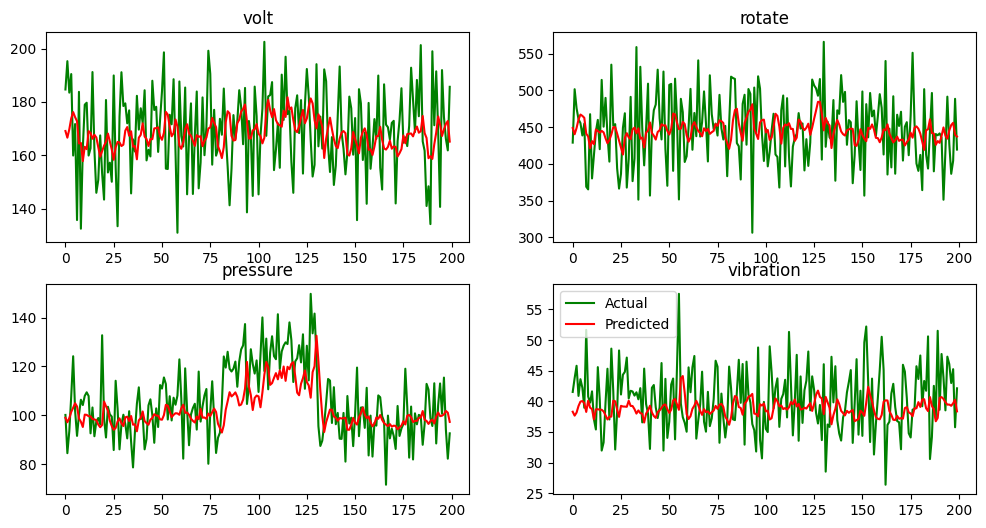

In [1134]:
plot_preds(y_pred_val, y_val_seq)

In [1135]:
##########################

# LSTM

In [1136]:
# LSTM model
def build_LSTM(X_train):
    shape_1 = X_train.shape[1]
    shape_2 = X_train.shape[2]
    model = Sequential()
    model.add(Input(shape=(shape_1, shape_2)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4))
    
    return model

In [1137]:
# Build LSTM
model_LSTM = build_LSTM(X_train_seq)

In [1138]:
# Compile and fit LSTM
model_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=[MeanSquaredError()])

In [1139]:
history_LSTM = model_LSTM.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), verbose=1, epochs=5)

Epoch 1/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 19.7538 - mean_squared_error: 1873.9553 - val_loss: 16.6284 - val_mean_squared_error: 814.5183
Epoch 2/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 16.6658 - mean_squared_error: 816.4041 - val_loss: 16.5711 - val_mean_squared_error: 809.4346
Epoch 3/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 16.5710 - mean_squared_error: 809.3021 - val_loss: 16.6411 - val_mean_squared_error: 825.9730
Epoch 4/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 16.5293 - mean_squared_error: 806.2266 - val_loss: 16.5200 - val_mean_squared_error: 811.8583
Epoch 5/5
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 16.4933 - mean_squared_error: 803.6355 - val_loss: 16.4448 - val_mean_squared_error: 802.7328


In [1140]:
# Save LSTM model
model_LSTM.save('../models/model_saves/model_LSTM.keras')

In [1141]:
y_pred_val_LSTM = model_LSTM.predict(X_val_seq)

4575/4575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [1142]:
# print(y_pred_val_LSTM)

In [1143]:
# print(y_val_seq)

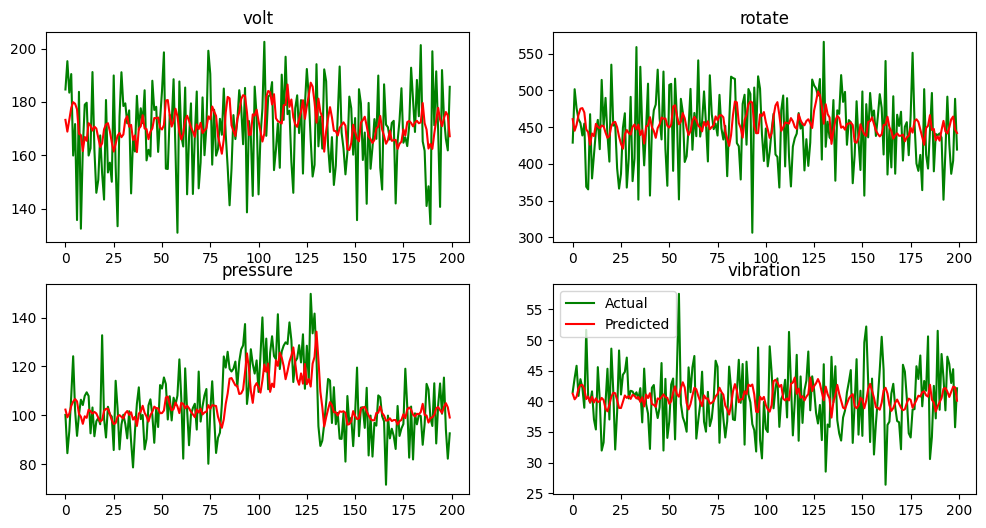

In [1144]:
# Plot predictions and actual values
plot_preds(y_pred_val_LSTM, y_val_seq)